In [1]:
import numpy as np
from numpy import random

# import scanpy for dimensionality reduction and plotting
import anndata as ad
from scanpy.api.tl import umap
from scanpy.api.tl import tsne
from scanpy.api.tl import diffmap
from scanpy.api import pp

# set viridis as the default color map
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpl.rcParams['image.cmap'] = 'viridis'

In [2]:
%load_ext autoreload
%autoreload 2

import tree
import simulation as sim
import sim_utils as sut
import count_model as cmod
import tree_utils as tu

random seed for reproducibility

In [3]:
rseed = 42
random.seed(rseed)

A topology with one branching event, where the two fates remain conjoined for a time and only then diverge

In [4]:
top = [["A", "B"], ["B", "C"], ["B", "D"], ["D", "E"], ["C", "F"]]

In [5]:
branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}
G = 500
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=1, modules=40)

In [6]:
uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)

/home/npapado/Documents/repos/prosstt/dev/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Mark the branches right after the branching event as committed lineages that only separate later:

In [7]:
uMs = sut.commited_branches(t, ["C", "D"], uMs)

The rest of the process is the same - add the genes to the tree, pick variance parameters and draw counts:

In [8]:
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

In [9]:
alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1
X, labs, brns, scalings = sim.sample_whole_tree(t, 5, alpha=alpha, beta=beta)

# normalize gene expression by library size
X = (X.transpose() / scalings).transpose()

In the dimensionality reduction we expect the branches after the branching event to be overlapping and only later diverge from each other.

         Falling back to preprocessing with `sc.pp.pca` and default params.


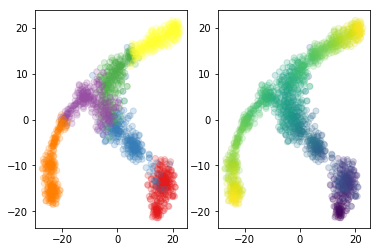

In [10]:
data = ad.AnnData(np.log(X+1))
pp.neighbors(data, use_rep='X')
tsne(data)
xtsne = data.obsm["X_tsne"]
br_names, indices = np.unique(brns, return_inverse=True)

fig, ax = plt.subplots(ncols=2)
# fig.set_size_inches(w=12, h=12)
ax[0].scatter(xtsne[:, 0], xtsne[:, 1], c=cm.Set1(indices), alpha=0.2)
ax[1].scatter(xtsne[:, 0], xtsne[:, 1], c=labs, alpha=0.2)

If we zoom in on the branching region we see that the branches mix very well for their first half and start separating later:

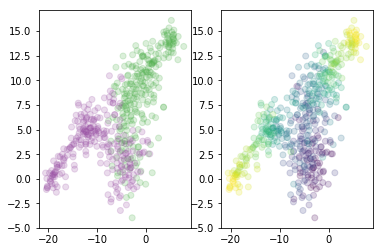

In [11]:
zoom_in = (indices == 2) | (indices == 3)
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(xtsne[zoom_in, 0],
              xtsne[zoom_in, 1],
              c=cm.Set1(indices[zoom_in]), alpha=0.2)
ax[1].scatter(xtsne[zoom_in, 0],
              xtsne[zoom_in, 1],
              c=labs[zoom_in], alpha=0.2)